# Variable Selection

*Hosmer, Lemeshow* suggest a univariate analysis of the variables to decide which variable to select for a first model. For continuous variables this is a two-sample t test and for categorial variable this is a test of proportion tables. If p > 0.25 the variable will be included in the next model. I implemented this in this notebook and the result is at the very end. 

In [1]:
options(repr.plot.width=6, repr.plot.height=5)
source("helpers.r")
library(tidyverse)
library(broom)
library(stringr)
df <- get_training_df()

Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is 

## Continuous Variables
### t-Test

In [2]:
t_test_continuous_variables  <- function(variable) {

x_0  <- df %>% 
  filter(target == "no_disease") %>%
  select(variable) %>%
  pull()

x_1  <- df %>%  
  filter(target == "disease") %>%
  select(variable) %>%
  pull()

test_result  <- t.test(x = x_0, y = x_1, var.equal = FALSE)
test_result_tidy  <- tidy(test_result)
test_result_tidy$p.value
}

In [3]:
continuous_variables <- c("chol", "trestbps", "ca", "thalach", "oldpeak", "age")
selection_continuous_variables  <- tibble(variable = continuous_variables,
                                         p_value = map_dbl(continuous_variables, t_test_continuous_variables))
                                 

selection_continuous_variables

variable,p_value
chol,3.560874e-01
trestbps,1.735806e-01
ca,1.295982e-10
thalach,3.422697e-11
oldpeak,5.890159e-12
age,1.167419e-03


Comparision with the fit of a logistic regression and filter for p values < 0.25:

In [4]:
formulas  <- paste0("target ~ ", continuous_variables)
  
p_values_glm  <- map_dbl(formulas, function(formula){
    
    fit <- glm(formula, data=df, family =binomial(link = "logit"))
    fit_tidy  <- tidy(fit)
    p_value  <-  fit_tidy %>% 
                    filter(term != "(Intercept)") %>% 
                    select(p.value) %>% 
                    pull()
    
    return(p_value)
    
})

selection_continuous_variables %>% mutate(p_values_glm = p_values_glm,
                                         selected = ifelse(p_value < 0.25, TRUE, FALSE)) 

variable,p_value,p_values_glm,selected
chol,3.560874e-01,3.586344e-01,FALSE
trestbps,1.735806e-01,1.729604e-01,TRUE
ca,1.295982e-10,7.765410e-09,TRUE
thalach,3.422697e-11,2.826759e-09,TRUE
oldpeak,5.890159e-12,5.295092e-10,TRUE
age,1.167419e-03,1.718051e-03,TRUE


The p values of the t-test and of the logistic regression are the same magnitue!

### Grouping

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)
Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


# A tibble: 6 x 5
  group count absent present proportion
  <fct> <int>  <dbl>   <dbl>      <dbl>
1 1         1      1       0      0    
2 2        16     13       3      0.188
3 3        54     35      19      0.352
4 4        92     44      48      0.522
5 5        76     18      58      0.763
6 6         4      0       4      1    


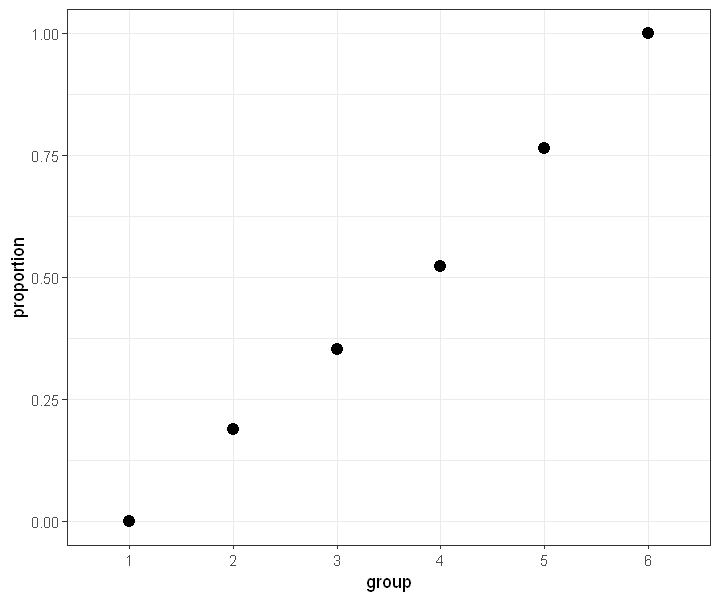

In [5]:

df <- get_training_df() #%>% mutate(disease = ifelse(target == "no_disease", 0, 1))

df <- df %>% count(cut_width(thalach, 25)) %>%
  mutate(group = `cut_width(thalach, 25)`)

groups <- df %>% select(group) %>% pull()


upper_cut <- function(s) {
  s <- str_split(s, ",")
  rigth <- s[[1]][2]
  if(str_detect(rigth, ".")) {
    rigth <- str_extract(rigth, "\\d.\\d*")
  } else {
    rigth <- str_extract(rigth, "\\d")
  }
  return(as.numeric(rigth))
}

groups <- as.character(groups)
breaks <- map_dbl(groups, upper_cut)

breaks <- c(-Inf, breaks, Inf)

df <- get_training_df()
df$group <- cut(df$thalach, 
                breaks=breaks, labels = 1:(length(breaks)-1))

df_groups <- df %>% mutate(disease = ifelse(target == "no_disease", 0, 1)) %>%
  group_by(group) %>%
  summarize(count = n(),
            absent = count - sum(disease),
            present = sum(disease),
            proportion = present / count)

print(df_groups)

ggplot(df_groups, aes(x = group, y = proportion)) + 
  geom_point(size = 3) + 
  theme_bw()

## Categorial Variables

In [6]:
categorial_variables <- c("fbs", "restecg", "sex", "exang", "cp", "slope", "thal")
test_result <- prop.test(table(df$thal, df$target))
test_result_tidy <- tidy(test_result)


selection_categorial_variables  <- tibble(variable = categorial_variables,
                                          p_value = map_dbl(categorial_variables, function(variable){
                                            test_result <- prop.test(table(df[[variable]], df$target))
                                            test_result_tidy <- tidy(test_result)
                                            return(test_result$p.value)
                                          })) %>%
                                    mutate(selected = ifelse(p_value < 0.25, TRUE, FALSE))


selection_categorial_variables

Warning message in prop.test(table(df$thal, df$target)):
"Chi-squared approximation may be incorrect"Warning message in prop.test(table(df[[variable]], df$target)):
"Chi-squared approximation may be incorrect"Warning message in prop.test(table(df[[variable]], df$target)):
"Chi-squared approximation may be incorrect"

variable,p_value,selected
fbs,7.907543e-01,FALSE
restecg,3.141365e-02,TRUE
sex,4.877941e-05,TRUE
exang,2.184984e-11,TRUE
cp,1.066468e-14,TRUE
slope,4.972793e-10,TRUE
thal,9.413762e-15,TRUE


So in summary:

In [7]:
selection_continuous_variables %>%  
    mutate(selected = ifelse(p_value < 0.25, TRUE, FALSE)) %>%
    bind_rows(selection_categorial_variables) %>%
    arrange(p_value)

variable,p_value,selected
thal,9.413762e-15,TRUE
cp,1.066468e-14,TRUE
oldpeak,5.890159e-12,TRUE
exang,2.184984e-11,TRUE
thalach,3.422697e-11,TRUE
ca,1.295982e-10,TRUE
slope,4.972793e-10,TRUE
sex,4.877941e-05,TRUE
age,1.167419e-03,TRUE
restecg,3.141365e-02,TRUE
